In [1]:
import detsim
import importlib
importlib.reload(detsim)

import matplotlib.pyplot as plt
import pickle
import numpy as np
import torch 
from tqdm import tqdm_notebook

tracks = pickle.load(open('tracks.p', 'rb'))
tracks['t'] = 0
tracks['t_start'] = 0
tracks['t_end'] = 0

tracks['dx'] = np.sqrt(pow(tracks['x_end']-tracks['x_start'], 2) +
                    pow(tracks['y_end']-tracks['y_start'], 2) +
                    pow(tracks['z_end']-tracks['z_start'], 2))
tracks['x'] = (tracks['x_end']+tracks['x_start'])/2
tracks['y'] = (tracks['y_end']+tracks['y_start'])/2
tracks['z'] = (tracks['z_end']+tracks['z_start'])/2
tracks['dE'] = np.abs(tracks['dE'])*1e3
tracks['dEdx'] = tracks['dE']/tracks['dx']
tracks['NElectrons'] = 0
tracks['longDiff'] = 0
tracks['tranDiff'] = 0

indeces = {c:i for i, c, in enumerate(tracks.columns)}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

track_tensor = torch.tensor(tracks.values).to(device)

quenching = detsim.Quenching(**indeces)
quenchedTracks = quenching(track_tensor)

drifting = detsim.Drifting(**indeces)
driftedTracks = drifting(quenchedTracks)

selectedTracks = driftedTracks[(driftedTracks[:, indeces['trackID']] > 6) & (driftedTracks[:, indeces['trackID']] < 10)]

In [2]:
tpc = detsim.TPC(t_sampling=1, n_pixels=1000, **indeces)

for t in tqdm_notebook(selectedTracks, desc='Processing tracks...'):
    img = tpc.depositTrackCharge(t)

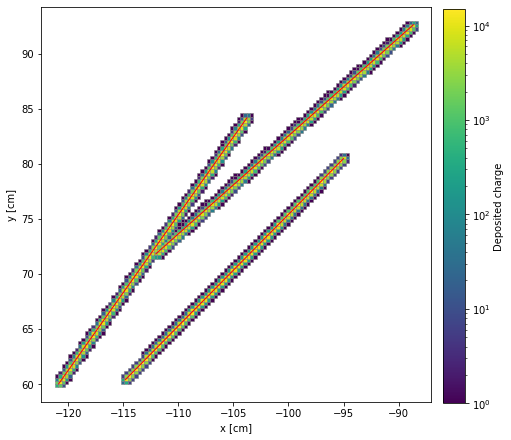

In [3]:
%matplotlib inline
fig, ax = plt.subplots(1,1,figsize=(6,6),constrained_layout=True)
ax.set_aspect('equal')

x = selectedTracks[:,indeces['x_start']].numpy(),selectedTracks[:,indeces['x_end']].numpy()
y = selectedTracks[:,indeces['y_start']].numpy(),selectedTracks[:,indeces['y_end']].numpy()
ax.plot(x,y,lw=1,c='r')

import matplotlib as mpl
import matplotlib.cm as cm

charges = [sum(tpc.activePixels[p].charge) for p in tpc.activePixels]
norm = mpl.colors.LogNorm(vmin=1, vmax=max(charges))
cmap = cm.viridis

m = cm.ScalarMappable(norm=norm, cmap=cmap)

for i, p in enumerate(tpc.activePixels):
    pixel = tpc.activePixels[p]
    rect = plt.Rectangle((pixel.id[0]*tpc.x_pixel_size-150, pixel.id[1]*tpc.y_pixel_size-150),
                         tpc.x_pixel_size,
                         tpc.y_pixel_size,
                         linewidth=0.5,
                         edgecolor='grey', 
                         facecolor=m.to_rgba(charges[i]))
    ax.add_patch(rect)

ax.set_xlabel("x [cm]")
ax.set_ylabel("y [cm]")

cax = fig.add_axes([ax.get_position().x1+0.13,ax.get_position().y0-0.05,0.05,ax.get_position().height*1.21])
_ = plt.colorbar(m,cax=cax,label='Deposited charge')

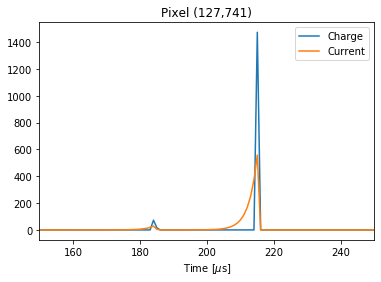

In [4]:
fig, ax = plt.subplots(1,1)
pixelID = tpc.getPixelFromCoordinates(-112,72.5)
ax.plot(tpc.anode_t, tpc.activePixels[pixelID].charge, label='Charge')
ax.plot(tpc.anode_t, tpc.activePixels[pixelID].current*10, label='Current')
ax.set_xlim(150,250)
ax.set_title("Pixel (%i,%i)" % (pixelID[0], pixelID[1]))
ax.set_xlabel("Time [$\mu$s]")
_ = ax.legend()